In [1]:
import cv2
import pytesseract
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from ultralytics import YOLO

In [2]:
data_dir = "google_images"

images = []
annotations = []
for fname in os.listdir(data_dir):
    if fname.lower().endswith(".jpg") or fname.lower().endswith(".jpeg") or fname.lower().endswith(".png"):
        images.append(os.path.join(data_dir, fname))
    elif fname.lower().endswith(".xml"):
        annotations.append(os.path.join(data_dir, fname))

In [3]:
data_records = []
for xml_file in annotations:
    tree = ET.parse(xml_file)
    root = tree.getroot()
    filename = root.findtext("filename")
    size = root.find("size")
    width = int(size.findtext("width"))
    height = int(size.findtext("height"))
    obj = root.find("object")
    plate_text = obj.findtext("name")
    bbox = obj.find("bndbox")
    xmin = int(bbox.findtext("xmin"))
    ymin = int(bbox.findtext("ymin"))
    xmax = int(bbox.findtext("xmax"))
    ymax = int(bbox.findtext("ymax"))
    data_records.append({
        "filename": filename,
        "width": width,
        "height": height,
        "xmin": xmin, "ymin": ymin, "xmax": xmax, "ymax": ymax,
        "plate_text": plate_text.strip()
    })

df = pd.DataFrame(data_records)
print("Total records:", len(df))
df.head(5)


Total records: 440


,filename,width,height,xmin,ymin,xmax,ymax,plate_text
0,0073797c-a755-4972-b76b-8ef2b31d44ab___new_IMG...,500,335,140,210,339,260,KA19TR02
1,00b42b2c-f193-4863-b92c-0245cbc816da___3e7fd38...,1280,853,184,572,292,648,TN21AT0492
2,018b52e6-e9a1-42c2-8ce7-0617e8c8e021___3e7fd38...,660,280,327,202,399,227,RJ27TC0530
3,03273806-bb1e-48da-8c8b-a0133a90197a___2014-Sk...,588,476,185,290,374,339,MH20CS9817
4,0369b20e-b432-4409-90f9-2420877aa386___8151536...,480,480,335,313,453,347,KL05AK3300


In [4]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
print(f"Training images: {len(train_df)}, Testing images: {len(test_df)}")

Training images: 352, Testing images: 88


In [5]:
import shutil

for sub in ["train/images", "train/labels", "val/images", "val/labels"]:
    os.makedirs(sub, exist_ok=True)

def create_yolo_label(txt_path, bbox, img_w, img_h):
    xmin, ymin, xmax, ymax = bbox
    # Convert to YOLO format (normalized center x, center y, width, height)
    x_center = (xmin + xmax) / 2.0 / img_w
    y_center = (ymin + ymax) / 2.0 / img_h
    w = (xmax - xmin) / img_w
    h = (ymax - ymin) / img_h
    with open(txt_path, "w") as f:
        f.write(f"0 {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}")

for _, row in train_df.iterrows():
    src_img = os.path.join(data_dir, row['filename'])
    dst_img = os.path.join("train/images", row['filename'])
    shutil.copy(src_img, dst_img)
    bbox = (row['xmin'], row['ymin'], row['xmax'], row['ymax'])
    label_path = os.path.join("train/labels", row['filename'].rsplit('.', 1)[0] + ".txt")
    create_yolo_label(label_path, bbox, row['width'], row['height'])

for _, row in test_df.iterrows():
    src_img = os.path.join(data_dir, row['filename'])
    dst_img = os.path.join("val/images", row['filename'])
    shutil.copy(src_img, dst_img)
    bbox = (row['xmin'], row['ymin'], row['xmax'], row['ymax'])
    label_path = os.path.join("val/labels", row['filename'].rsplit('.', 1)[0] + ".txt")
    create_yolo_label(label_path, bbox, row['width'], row['height'])

In [6]:
data_yaml = """
names:
  0: license_plate
nc: 1
train: train/images
val: val/images
"""
with open("data.yaml", "w") as f:
    f.write(data_yaml)
print("YOLO data configuration written to data.yaml")


YOLO data configuration written to data.yaml


In [8]:
model = YOLO("yolov8n.pt")

results = model.train(data="data.yaml", epochs=50, imgsz=640, batch=32, lr0= 0.0005, lrf=0.1, augment=True)

Ultralytics 8.3.228 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.1, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pr

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         88         88      0.999      0.989      0.995      0.864
Speed: 0.1ms preprocess, 7.3ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /kaggle/working/runs/detect/train


In [44]:
trained_model = YOLO("runs/detect/train/weights/best.pt")

pred_texts = []
actual_texts = list(test_df['plate_text'])

for filename in test_df['filename']:
    img_path = os.path.join("val/images", filename)
    results = trained_model.predict(source=img_path, verbose=False)
    result = results[0]
    box = result.boxes[0]
    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
    image = cv2.imread(img_path)
    plate_img = image[y1:y2, x1:x2]
    gray_img = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)
    config = "--psm 6"
    text = pytesseract.image_to_string(gray_img, config=config)
    text = text.strip()
    # remove spaces and newlines, uppercase for consistency
    text = "".join(filter(str.isalnum, text)).upper()
    pred_texts.append(text)

test_df['pred_text'] = pred_texts
print(test_df[['plate_text', 'pred_text']].head(3))


     plate_text   pred_text
265  MH06AW8929   HOSAW8909
78      ASM1634    ASMM1084
347  HR26DG6167  HR26DG6167


In [45]:
# Calculate character-level accuracy
total_chars = 0
correct_chars = 0
for actual, pred in zip(test_df['plate_text'], test_df['pred_text']):
    pred = "" if pred is None else str(pred)
    total_chars += len(actual)
    # extra pred chars and missing pred chars are considered incorrect
    for i, ch in enumerate(actual):
        if i < len(pred) and pred[i] == ch:
            correct_chars += 1

char_accuracy = correct_chars / total_chars
print(f"Character-level OCR accuracy: {char_accuracy*100:.2f}% ({correct_chars}/{total_chars} characters correct)")


Character-level OCR accuracy: 45.86% (388/846 characters correct)


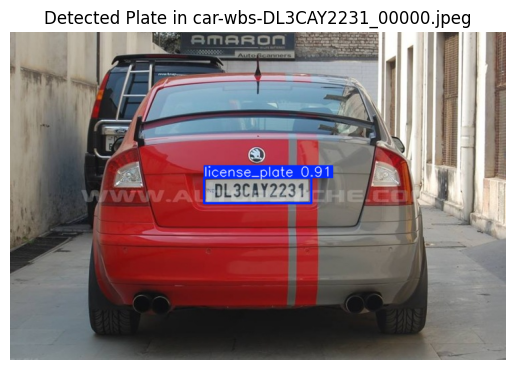

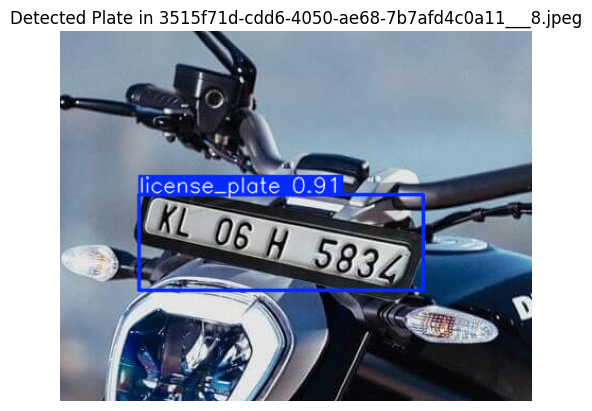

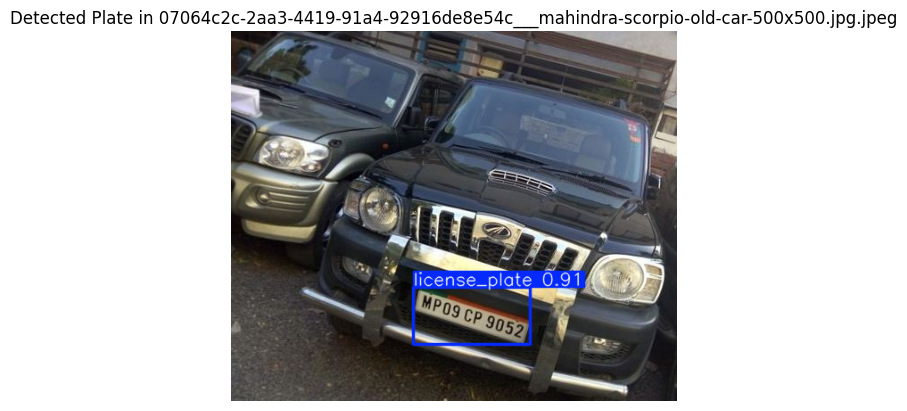

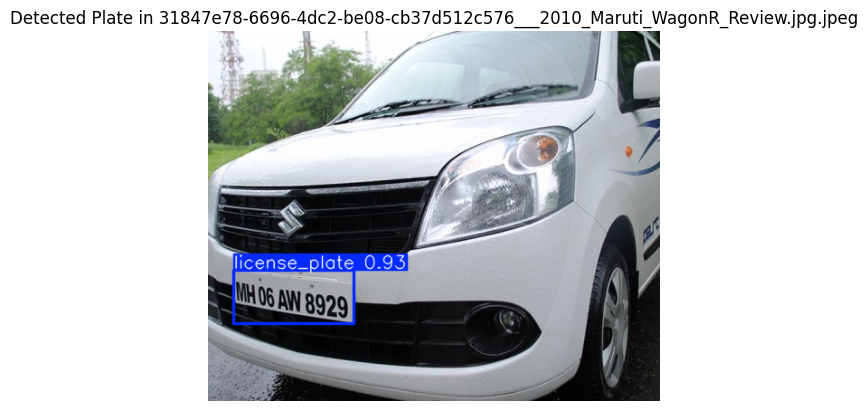

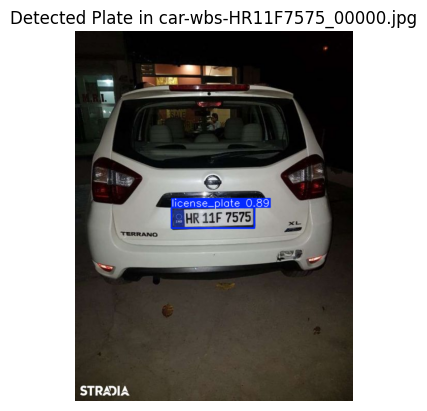

In [46]:
# 5 random test images to visualize
sample_images = test_df.sample(5, random_state=1)['filename'].tolist()
for fname in sample_images:
    img_path = os.path.join("val/images", fname)
    results = trained_model.predict(source=img_path, verbose=False)
    result = results[0]
    plotted_img = result.plot()
    plotted_img = cv2.cvtColor(plotted_img, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(plotted_img)
    plt.axis('off')
    plt.title(f"Detected Plate in {fname}")
    plt.show()
